In [2]:
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)

import sys
sys.path.append("../tfti")
from tfti_batched_inference import *

In [3]:
config = get_config(
    problem="genomics_binding_deepsea_gm12878",
    model="tfti_transformer",
    hparams_set="tfti_transformer_base",
    hparams="",
    checkpoint_path="~/Downloads/6-64-25/model.ckpt-210001",
)

In [63]:
from tensorflow.contrib.framework.python.framework import checkpoint_utils

def get_variables_from_checkpoint(checkpoint_path, excluded_scopes=None):
    excluded_scopes = excluded_scopes or []
    with tf.Graph().as_default():
        var_spec_list = checkpoint_utils.list_variables(checkpoint_path)
        var_dict = {
            n: tf.get_variable(n, shape=s)
            for n, s in var_spec_list  # (name, shape)
            if not any(
                n.startswith(e)
                for e in excluded_scopes
            )
        } 
        vars_to_restore = tf.contrib.slim.get_variables_to_restore()
        saver = tf.train.Saver(vars_to_restore)
        with tf.Session() as sess:
            saver.restore(sess, checkpoint_path)
            return sess.run(var_dict)
            
var_dict = get_variables_from_checkpoint(
    config.checkpoint_path, excluded_scopes=["training", "global_step"])

In [84]:
symbol_modality_var_dict = {n: v for n, v in var_dict.items() if "symbol_modality" in n}
symbol_modality_var_keys_sorted = sorted(symbol_modality_var_dict.keys(), key=lambda x: int(x.split("_")[-1]))
symbol_modality_var_vals_sorted = [symbol_modality_var_dict[k] for k in symbol_modality_var_keys_sorted]
input_emb_var = np.concatenate(symbol_modality_var_vals_sorted, axis=0)

In [115]:
from sklearn.decomposition import PCA
X = input_emb_var
pca = PCA(n_components=2)
X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)

[0.01884679 0.01000982]
[4.032717  2.9389508]


Populating the interactive namespace from numpy and matplotlib


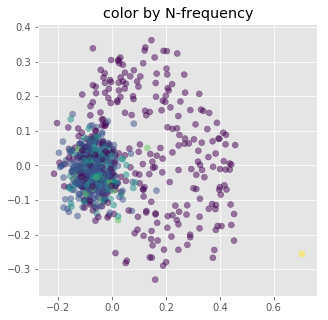

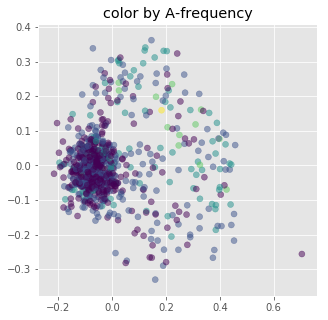

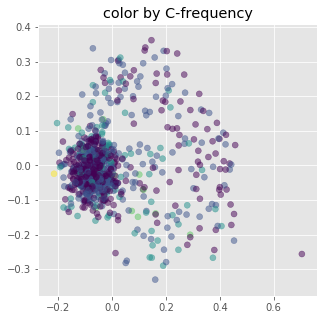

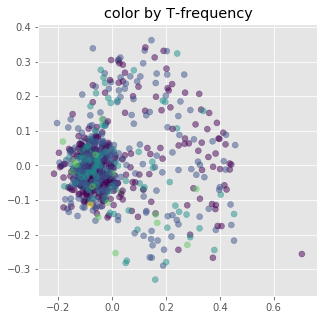

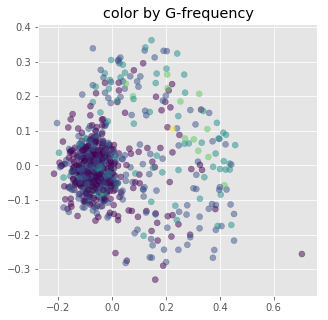

In [130]:
%pylab inline
plt.style.use("ggplot")

# plt.figure(figsize=(20., 10.))

p1, p2 = X.T

from tensor2tensor.data_generators import dna_encoder

encoder = dna_encoder.DNAEncoder(problem.chunk_size)
sorted_tokens = [("",), ("",)] + [v for k, v in sorted(encoder._ids_to_tokens.items())]
assert len(sorted_tokens) == encoder.vocab_size

count_chr_fn = lambda x, c: np.sum(np.array(list(x)) == c)
get_count_chr_fn = lambda c: lambda x: count_chr_fn(x, c)

for c in "NACTG":
    plt.figure(figsize=(5., 5.))
    color = [get_count_chr_fn(c)(x) for x in sorted_tokens]
    plt.scatter(x=p1, y=p2, c=color, alpha=0.5)
    plt.title(f"color by {c}-frequency")
    plt.show()

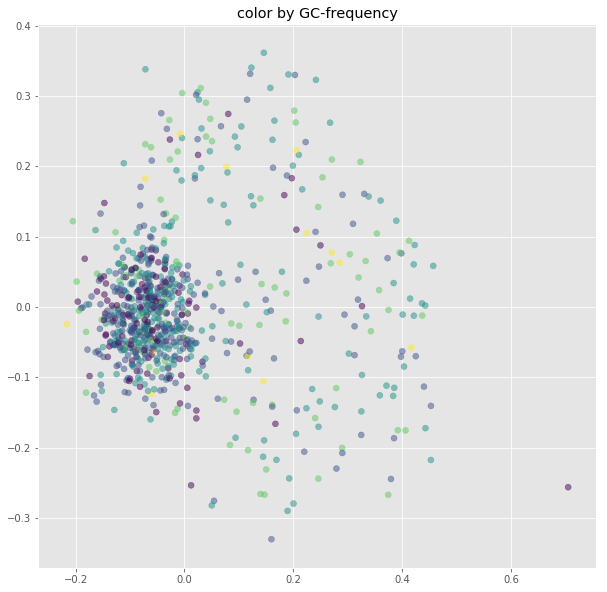

In [132]:
plt.figure(figsize=(10., 10.))
color = [get_count_chr_fn("G")(x) + get_count_chr_fn("C")(x) for x in sorted_tokens]
plt.scatter(x=p1, y=p2, c=color, alpha=0.5)
plt.title(f"color by GC-frequency")
plt.show()